Presentation date: July 21, 2022

# Unsupervised Learning - Tweet Analysis 

In this group project, we collected tweets with a specific hashtag (in this case, #fitness), processed them with NLP techniques, and used K-Means clustering to classify tweets into sub-groups. 

### Design
1. We used twitter's developer api in combination with a package called [tweepy](https://www.tweepy.org/) to collect tweets by hashtag. 
2. After collecting 5000 tweets, we used tools from [NLTK](https://www.nltk.org/) and TF-IDF vectorization to build a feature matrix of tweets.
3. Next, Principle Component Analysis (PCA) was applied reduce the number of features to 2500.
4. Using K-Means clustering, we plotted the within cluster sum of squares (WCSS) and silhouette scores for a range of clusters to determine the optimal number of clusters. 
5. We sampled each cluster randomly to identify what the clustering "means" i.e. what is the similarity within the cluster
6. Finally, we used [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed the data in 2D and view the labelled clusters in the reduced space.

### Conclusions
We saw some pretty interesting results from the visualization! A large proportion of tweets we classified as 'miscellaneous' (no obvious identifiers) and 'advice', which was also pretty general, were grouped together in the centre of the graph. Then we see tight groupings of highly specific tweets (Go!Bots spam tweets, crypto/NFT-based tweets) separate from the bulk of fitness tweets. On the edge, we see clickbait (links to articles making fantastic or outrageous claims), and a sort of archipelago of weight loss, nutrition, yoga, beauty, and motivation tweets. Finally, a small but obvious cluster of news tweets exists. 

In [817]:
# imports
import statsmodels.api as sm
import pandas as pd
import numpy as np
import sklearn.metrics as m
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [622]:
# Initialize the data
df = pd.read_csv('fitness_tweets.csv', lineterminator='\n')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop_duplicates()
# Get stopwords
stop = stopwords.words('english')
to_add = ['https', 'http', 'com', 'www', 'fitness']
stop.extend(to_add)
df.columns = ['tweets']

In [628]:
# Clean the tweets to produce tweets with only alpha values not in the list of stopwords
df['tweets_clean'] = df.tweets.astype(str).apply(
    lambda x: ' '.join([word for word in word_tokenize(x) if word.isalpha() and word.casefold() not in stop])
)

In [656]:
# TF-IDF vectorization comprising unigrams and bigrams, with a feature cap of 25000
tv = TfidfVectorizer(ngram_range=(1, 2), max_features=2500)
word_vectors = tv.fit_transform(df.tweets_clean)
word_vectors = np.asarray(word_vectors.todense())

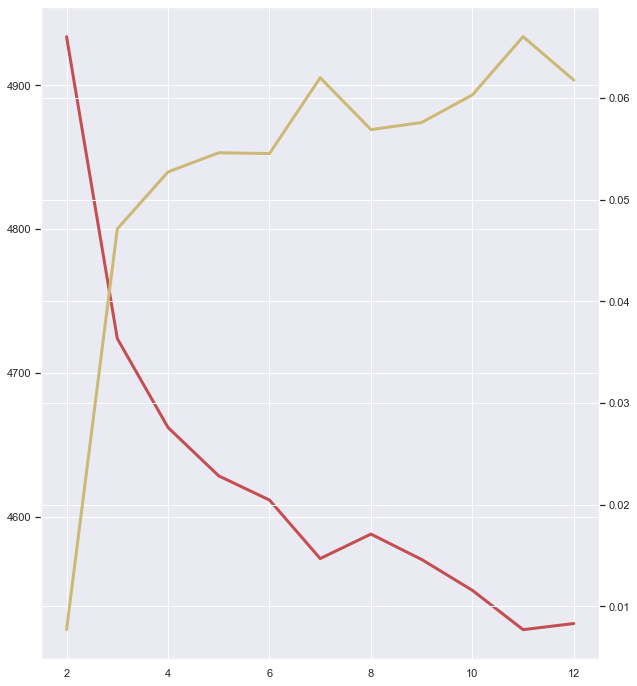

In [657]:
# Plot a range of cluster sizes to measure silhouette as well as elbow plot
from sklearn.cluster import KMeans, MiniBatchKMeans
wcss = []
sil_scores = []
range_ = range(2, 13)

for i in range_:
    kmeans = MiniBatchKMeans(i, random_state=42)
    kmeans.fit(word_vectors)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil_scores.append(m.silhouette_score(word_vectors, labels))

fig, ax = plt.subplots(figsize=(10, 12))
ax2 = ax.twinx()
ax.plot(range_, wcss, c='r', lw=3)
ax2.plot(range_, sil_scores, c='y', lw=3)

In [658]:
# The sweet spot here is 11 clusters
kmeans = KMeans(n_clusters=11, random_state=42)
labels = kmeans.fit_predict(word_vectors)

In [659]:
df['labels'] = labels

In [660]:
# View size of clusters
df.labels.value_counts()

4     2601
0      585
3      330
5      327
2      250
9      235
8      233
10     170
1      165
6       82
7       69
Name: labels, dtype: int64

In [636]:
# View keyword frequency
for label in np.unique(labels):
    print(label, df.loc[df.labels == label].tweets_clean.str.split(expand=True).stack().value_counts()[:15].index.values)

0 ['gym' 'workout' 'fitnessmotivation' 'fit' 'bodybuilding' 'motivation'
 'training' 'gymlife' 'gymmotivation' 'muscle' 'health' 'fitfam'
 'lifestyle' 'Gym' 'love']
1 ['Diet' 'Health' 'WeightLoss' 'LoseWeight' 'Weight' 'May' 'Fat' 'Eating'
 'Loss' 'Help' 'Gut' 'Benefits' 'Cause' 'Reduce' 'Blood']
2 ['love' 'model' 'style' 'beautiful' 'fashion' 'LIKE' 'COMMENT' 'SHARE'
 'instagood' 'like' 'beauty' 'photooftheday' 'follow' 'photography'
 'travel']
3 ['exercise' 'workout' 'health' 'gym' 'Exercise' 'weightloss' 'today'
 'healthy' 'get' 'training' 'amp' 'cardio' 'Health' 'diet' 'body']
4 ['health' 'amp' 'workout' 'gym' 'Health' 'day' 'get' 'motivation' 'sports'
 'training' 'weightloss' 'today' 'body' 'via' 'running']
5 ['health' 'healthy' 'wellness' 'healthylifestyle' 'healthyious'
 'motivation' 'nutrition' 'lifestyle' 'healthyliving' 'workout' 'Health'
 'fit' 'food' 'gym' 'healthcare']
6 ['weightloss' 'healthy' 'Stay' 'July' 'giveaway' 'nftcommunity' 'nft'
 'crypto' 'updates' 'competitions

### Labelling the clusters

We examined the clusters through keyword frequency analysis as well as random sampling of the tweets in each group to come up with names for each cluster. The corresponding labels are as follows:  

0. Motivational  
1. Clickbait articles  
2. Beauty blogger 
3. Fitness advice 
4. Miscellaneous 
5. Nutrition and health  
6. Crypto 
7. Fitness news
8. Weight loss  
9. Go!Bots bot
10. Yoga  



In [654]:
# Use tSNE manifold learning to reduce dimensionality for plotting

from sklearn.manifold import TSNE

In [655]:
tsne = TSNE()

In [667]:
twod = tsne.fit_transform(word_vectors)

/Users/josephpeart/opt/anaconda3/envs/bcenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/josephpeart/opt/anaconda3/envs/bcenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


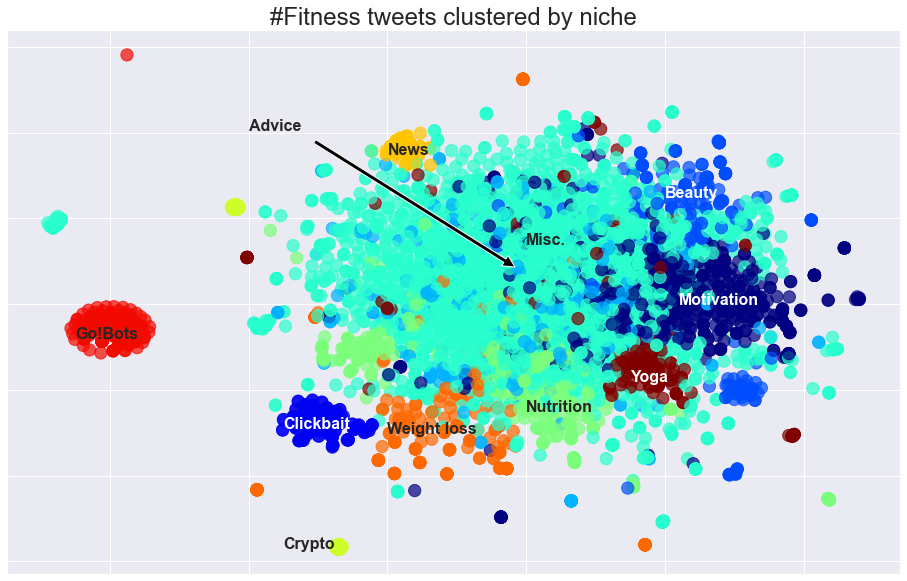

In [837]:
# Plot each cluster with colours based on their label

plt.figure(figsize=(16, 10))
plt.scatter(*twod.T, c=labels, alpha=.7, s=150, cmap=plt.cm.get_cmap('jet', 11))

params = dict(
size=16,
fontweight='demibold')

plt.annotate('Go!Bots', (-65, -8), **params)
plt.annotate('Misc.', (0, 14), **params)
plt.annotate('Clickbait', (-35, -29), c='w', **params)
plt.annotate('Beauty', (20, 25), c='w', **params)
plt.annotate('Advice', xy=(0, 7), xytext=(-40, 40),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            clip_on=True, **params)
plt.annotate('Nutrition', (0, -25), **params)
plt.annotate('Crypto', (-35, -57), **params)
plt.annotate('News', (-20, 35), **params)
plt.annotate('Yoga', (15, -18), c='w', **params)
plt.annotate('Motivation', (22, 0), c='w', **params)
plt.annotate('Weight loss', (-20, -30), **params)
plt.title("#Fitness tweets clustered by niche", size=24)
plt.tick_params( axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)

plt.show()